In [15]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'
%pylab inline

from __future__ import division
import rdflib
from rdflib.graph import Graph, ConjunctiveGraph
from rdflib import Graph, URIRef, BNode, Literal
from rdflib import RDF
from rdflib import Namespace
from rdflib.namespace import OWL, RDF, RDFS, FOAF, XSD
from SPARQLWrapper import SPARQLWrapper, JSON
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry.multipolygon import MultiPolygon
from shapely import wkt
from descartes import PolygonPatch
from shapely.geometry.polygon import LinearRing
import seaborn as sns
import pandas as pd
from matplotlib.collections import PatchCollection

from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

Populating the interactive namespace from numpy and matplotlib


In [2]:
def plotPopulation(dataSwiss, string, string2, f1, f2):
    df = pd.DataFrame()
    df['name'] = dataSwiss[string]
    df['pop'] = dataSwiss[string2]
    df['pop'] = df['pop'].astype(int)
    df = df.drop_duplicates('name', keep='last')
    df = df[df['pop']>0].reset_index(drop=True)
    df = df.sort_values('pop')
    
    colors = 'Greens'
    bg_color = 'black'
    fg_color = 'white'

    fig = plt.figure(facecolor=bg_color, edgecolor=fg_color, figsize=(20,7.5))
    axes = plt.axes((0.1, 0.1, 0.8, 0.8), axisbg=bg_color)
    axes.xaxis.set_tick_params(color=fg_color, labelcolor=fg_color)
    axes.yaxis.set_tick_params(color=fg_color, labelcolor=fg_color)
    for spine in axes.spines.values():
        spine.set_color(fg_color)
    axes.grid(False)
    x = np.linspace(0, 2 * np.pi, 100)
    y = np.sin(x)

    sns.set(font_scale = 2)
    gplot = sns.barplot(x= "name", y='pop', data=df, palette=colors)
    gplot.set_xticklabels(df.name, rotation=90);
    plt.ylabel('Population', color=fg_color);
    plt.xlabel(string, color=fg_color);
    
    plt.tick_params(axis='x', which='major', labelsize=f1);
    plt.tick_params(axis='y', which='major', labelsize=f2);
    
def plotGeo(cmap, value, string, coord):
    
    norm = matplotlib.colors.Normalize(min(value), max(value))
    color_producer = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)
    fig,axes = plt.subplots(figsize=(18,12))
    
    for i,j in enumerate(coord):
        p = wkt.loads(j)
        cc = color_producer.to_rgba( value[i] )
        ptchs   = []
        for polygon in p:
            patch = PolygonPatch(polygon, facecolor=cc,  edgecolor= 'k', alpha=0.5, zorder=2)
            ptchs.append(patch)
            h = PatchCollection(ptchs,   facecolor=cc, linewidths = 1)
            axes.add_patch(patch)
    axes.set_xlim(5.9, 10.5)
    axes.set_ylim(45.7,48)

    axes.set_ylabel('Latitude',size = 25)
    axes.set_xlabel('Longitude',size= 25)
    axes.set_title(string,size= 30)

    h.set(array = value, cmap=cmap)
    cbaxes = inset_axes(axes, width="50%", height="3%", loc=2) 
    cb = plt.colorbar(h, cax=cbaxes, orientation='horizontal',format='%.2e')
    cb.ax.xaxis.set_tick_params(rotation=45, labelsize=12)

# Table of Contents
* [1. Vocabularies](#1.-Vocabularies)
* [2. Create the Ontology](#2.-Create-the-Ontology)
* [3. Online Linked Data](#3.-Online-Linked-Data)
    * [3.1 Download](#3.1-Download)
    * [3.2 Store the Data](#2.2-Store-the-Data)
* [3. Plot Cantons Population](#3.-Plot-Cantons-Population)
* [4. Plot District Population](#4.-Plot-District-Population)

# 1. Vocabularies

In [3]:
schema = rdflib.Namespace('http://schema.org/')
time   = rdflib.Namespace('http://www.w3.org/2006/time#')
dbo    = rdflib.Namespace('http://dbpedia.org/ontology/')
dbp    = rdflib.Namespace('http://dbpedia.org/property/')
res    = rdflib.Namespace('http://dbpedia.org/resource/')
rdf    = rdflib.Namespace('http://www.w3.org/1999/02/22-rdf-syntax-ns#')
rdfs   = rdflib.Namespace('http://www.w3.org/2000/01/rdf-schema#')

# 3. Online Linked Data

## 3.1 Retrieve Data

In [4]:
sparql = SPARQLWrapper("https://sparql.geo.admin.ch/sparql")
query = """
PREFIX schema: <http://schema.org/>
PREFIX gn: <http://www.geonames.org/ontology#>
PREFIX geo: <http://www.opengis.net/ont/geosparql#>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX wikibase: <http://wikiba.se/ontology#>
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX fn: <http://www.w3.org/2005/xpath-functions#>
PREFIX dbp: <http://dbpedia.org/property/>

select ?Municipality ?Name 
?bfsNumber ?Geometry ?Coords ?PostalCode ?Date ?populationMunicipality ?areaMunicipality
?District ?districtName ?populationDistrict ?bfsNumberDistrict
?Canton ?cantonName ?populationCanton ?bfsNumberCanton ?cantonCoords
where
{
    ?Municipality a gn:A.ADM3.
    ?Municipality schema:name ?Name .
    ?Municipality <https://ld.geo.admin.ch/def/bfsNumber> ?bfsNumber .
    ?Municipality <http://purl.org/dc/terms/issued> ?Date .
    ?Municipality geo:hasGeometry ?Geometry.
    ?Municipality geo:hasGeometry ?Geometry.
    ?Municipality gn:population ?populationMunicipality. 
    ?Municipality dbp:area ?areaMunicipality. 
    ?Geometry geo:asWKT ?Coords.
    
    OPTIONAL {
    ?Municipality gn:parentADM1 ?Canton.
    ?Canton a gn:A.ADM1 .
    ?Canton schema:name ?cantonName .
    ?Canton gn:population ?populationCanton .
    ?Canton <https://ld.geo.admin.ch/def/bfsNumber> ?bfsNumberCanton .
    }
    
    OPTIONAL {
    ?Municipality gn:parentADM2 ?District.
    ?District schema:name ?districtName .
    ?District gn:population ?populationDistrict .
    ?District <https://ld.geo.admin.ch/def/bfsNumber> ?bfsNumberDistrict .
    }    
    
    {
    SELECT DISTINCT (xsd:integer(?bfs) AS ?bfsNumber) 
    ?WikidataURI ?GeoNamesURI ?PostalCode ?MunicipalityCode 
        WHERE {
            SERVICE <https://query.wikidata.org/bigdata/namespace/wdq/sparql>
            {
                ?WikidataURI wdt:P771 ?bfs . #look for bfs number in WD
                OPTIONAL { ?WikidataURI wdt:P1566 ?GeoNamesId}
                OPTIONAL { ?WikidataURI wdt:P281 ?PostalCode}
            }
          BIND(IRI(CONCAT(STR("http://sws.geonames.org/"), ?GeoNamesId, "/")) AS ?GeoNamesURI)
        }
    }

}
ORDER BY DESC(?Name)
"""

In [5]:
sparql.setQuery(query)
sparql.setReturnFormat(JSON)
results = sparql.query().convert()

In [6]:
c = 0
code = []
zipCode = []
munCoord = []
date = []
munName = []
mun = []
munPopulation = []
munArea = []

disCode = []
disName = []
disPopulation = []

canCode = []
canName = []
canPopulation = []

cantonCoords = []

for result in results["results"]["bindings"]:
    ## Municpality
    
    mun.append(result["Municipality"]["value"])
    code.append(result["bfsNumber"]["value"])
    munCoord.append(result["Coords"]["value"])
    munName.append(result["Name"]["value"])
    date.append(result["Date"]["value"])
    munPopulation.append(result["populationMunicipality"]["value"])
    munArea.append(result["areaMunicipality"]["value"])
    
    c = c + 1
    nameC = "municipality%d"%c
    idS = URIRef(FOCUS[nameC])
    g.add((idS, RDF.type, dbo.municipality))
    
    tmp = Literal(result["municipalityName"]['value'])
    g.add((idS, FOAF.name, tmp))
    
    tmp = Literal(result["Population"]['value'])
    g.add((idS, dbo.populationTotal, tmp))
    
    tmp = Literal(result["MunicipalityCode"]['value'])
    g.add((idS, dbo.municipalityCode, tmp))
    
    
    if 'PostalCode' in result:
        zipCode.append(result["PostalCode"]["value"])
    else:
        zipCode.append(0)     


    ## District
    if 'districtName' in result:
        disName.append(result["districtName"]["value"])
    else:
        disName.append(0)

        
    if 'populationDistrict' in result:
        disPopulation.append(result["populationDistrict"]["value"])
    else:
        disPopulation.append(0)
        
    if 'bfsNumberDistrict' in result:
        disCode.append(result["bfsNumberDistrict"]["value"])
    else:
        disCode.append(0)
        
        
    ## Canton
    
    if 'cantonName' in result:
        canName.append(result["cantonName"]["value"])
    else:
        canName.append(0)
        

    if 'populationCanton' in result:
        canPopulation.append(result["populationCanton"]["value"])
    else:
        canPopulation.append(0)
        
    if 'bfsNumberCanton' in result:
        canCode.append(result["bfsNumberCanton"]["value"])
    else:
        canCode.append(0)


In [7]:
dataSwiss = pd.DataFrame({'Municipality':munName,'zipCode':zipCode, 'Date':date,
                          'Code':code,'munCoord':munCoord,'munArea':munArea, 
                          'District':disName, 'districtPopulation':disPopulation, 
                          'districtCode':disCode,
                          'Canton': canName, 'cantonPopulation': canPopulation, 
                          'cantonCode':canCode,'populationMunicipality':munPopulation      
                    } )

## Plot Cantons Population

### Extract Geo Information from Open Linked Data

In [8]:
sparql = SPARQLWrapper("https://sparql.geo.admin.ch/sparql")
query = """
PREFIX schema: <http://schema.org/>
PREFIX gn: <http://www.geonames.org/ontology#>
PREFIX geo: <http://www.opengis.net/ont/geosparql#>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX wikibase: <http://wikiba.se/ontology#>
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX fn: <http://www.w3.org/2005/xpath-functions#>

select ?Coords ?bfsNumberCanton
where
{
    ?Canton a gn:A.ADM1 .
    ?Canton <https://ld.geo.admin.ch/def/bfsNumber> ?bfsNumberCanton .
    ?Canton geo:hasGeometry ?Geometry.
    ?Geometry geo:asWKT ?Coords.
}
ORDER BY DESC(?Name)
"""

In [9]:
sparql.setQuery(query)
sparql.setReturnFormat(JSON)
results = sparql.query().convert()

### Merge Population Information with Geo Data

In [10]:
canCode = []
canGeomentry = []
for result in results["results"]["bindings"]:
    canCode.append(result["bfsNumberCanton"]["value"])
    canGeomentry.append(result["Coords"]["value"])

dfCan = pd.DataFrame({'cantonCode':canCode,'canCoord':canGeomentry})
dfCamTmp = pd.DataFrame({'cantonCode':dataSwiss.cantonCode, 
                         'cantonPopulation':dataSwiss.cantonPopulation,
                         'Canton': dataSwiss.Canton
                        })

dfCan = pd.merge(dfCan,dfCamTmp, on='cantonCode')
dfCan = dfCan.drop_duplicates('cantonCode', keep='last')
dfCan = dfCan[dfCan['cantonPopulation']>0].reset_index(drop=True)
dfCan.cantonPopulation = dfCan.cantonPopulation.astype(int)
pop = dfCan.cantonPopulation

In [11]:
value = pop
cmap = plt.get_cmap('ocean_r')
string = 'Canton Population'

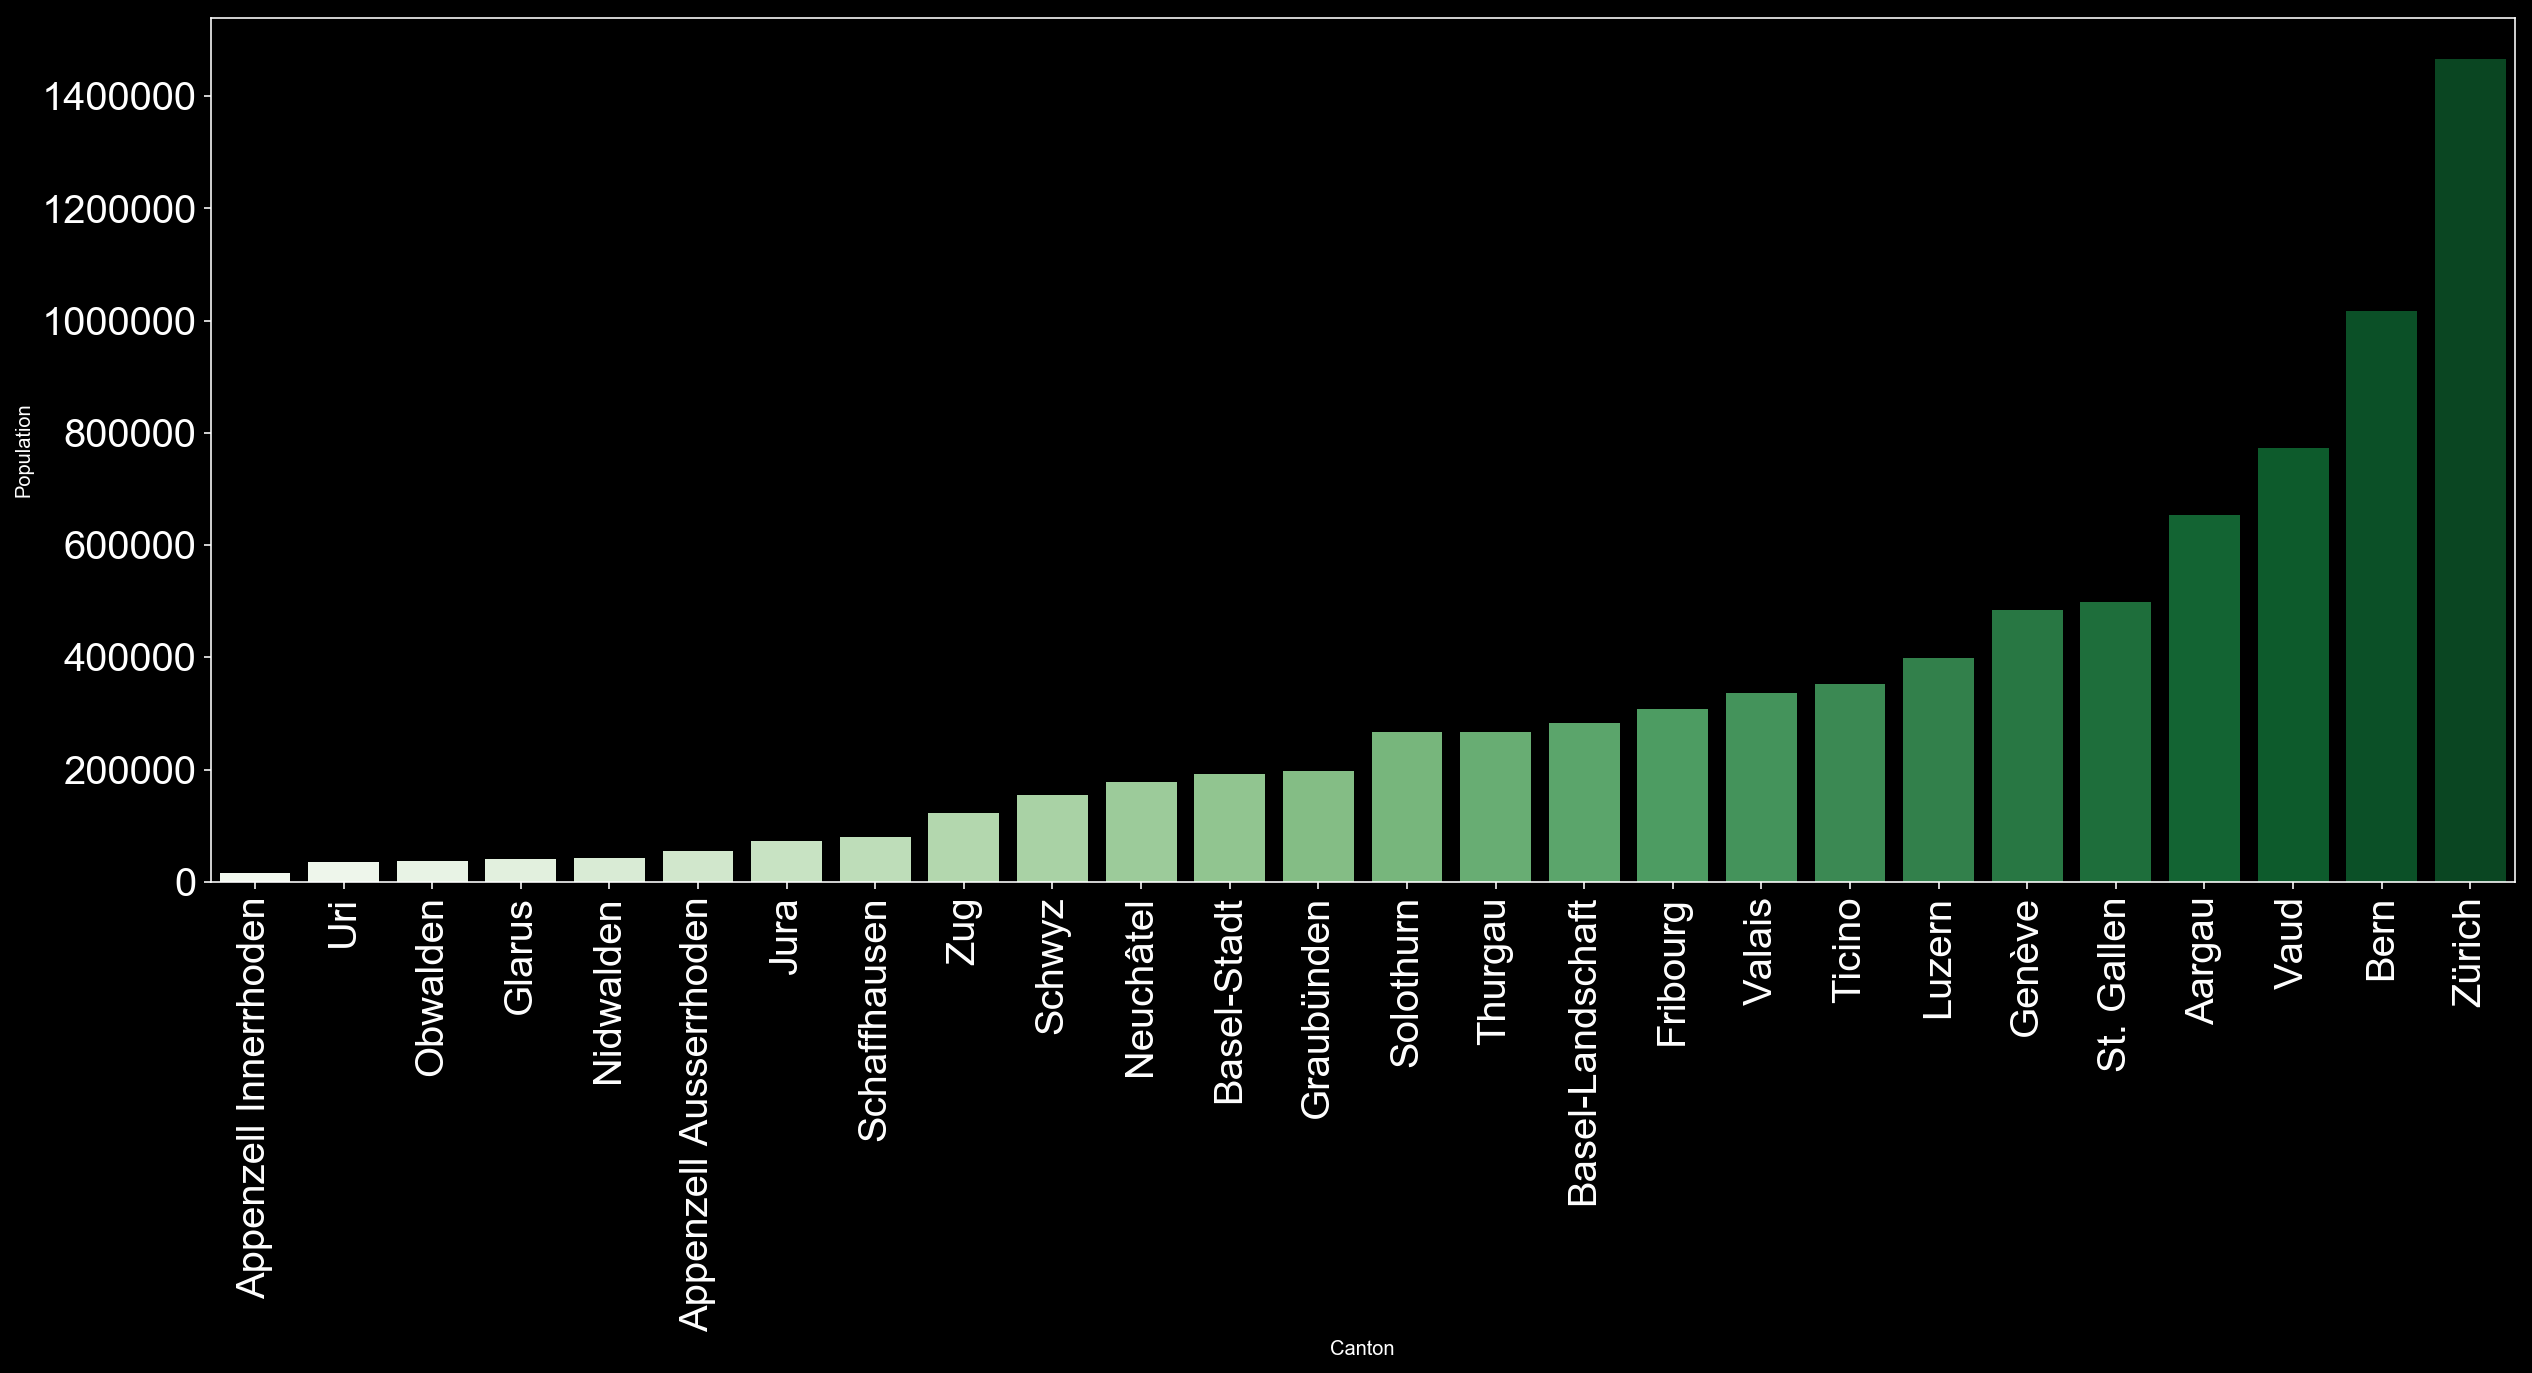

In [12]:
plotPopulation(dataSwiss, 'Canton', 'cantonPopulation', 20, 20)

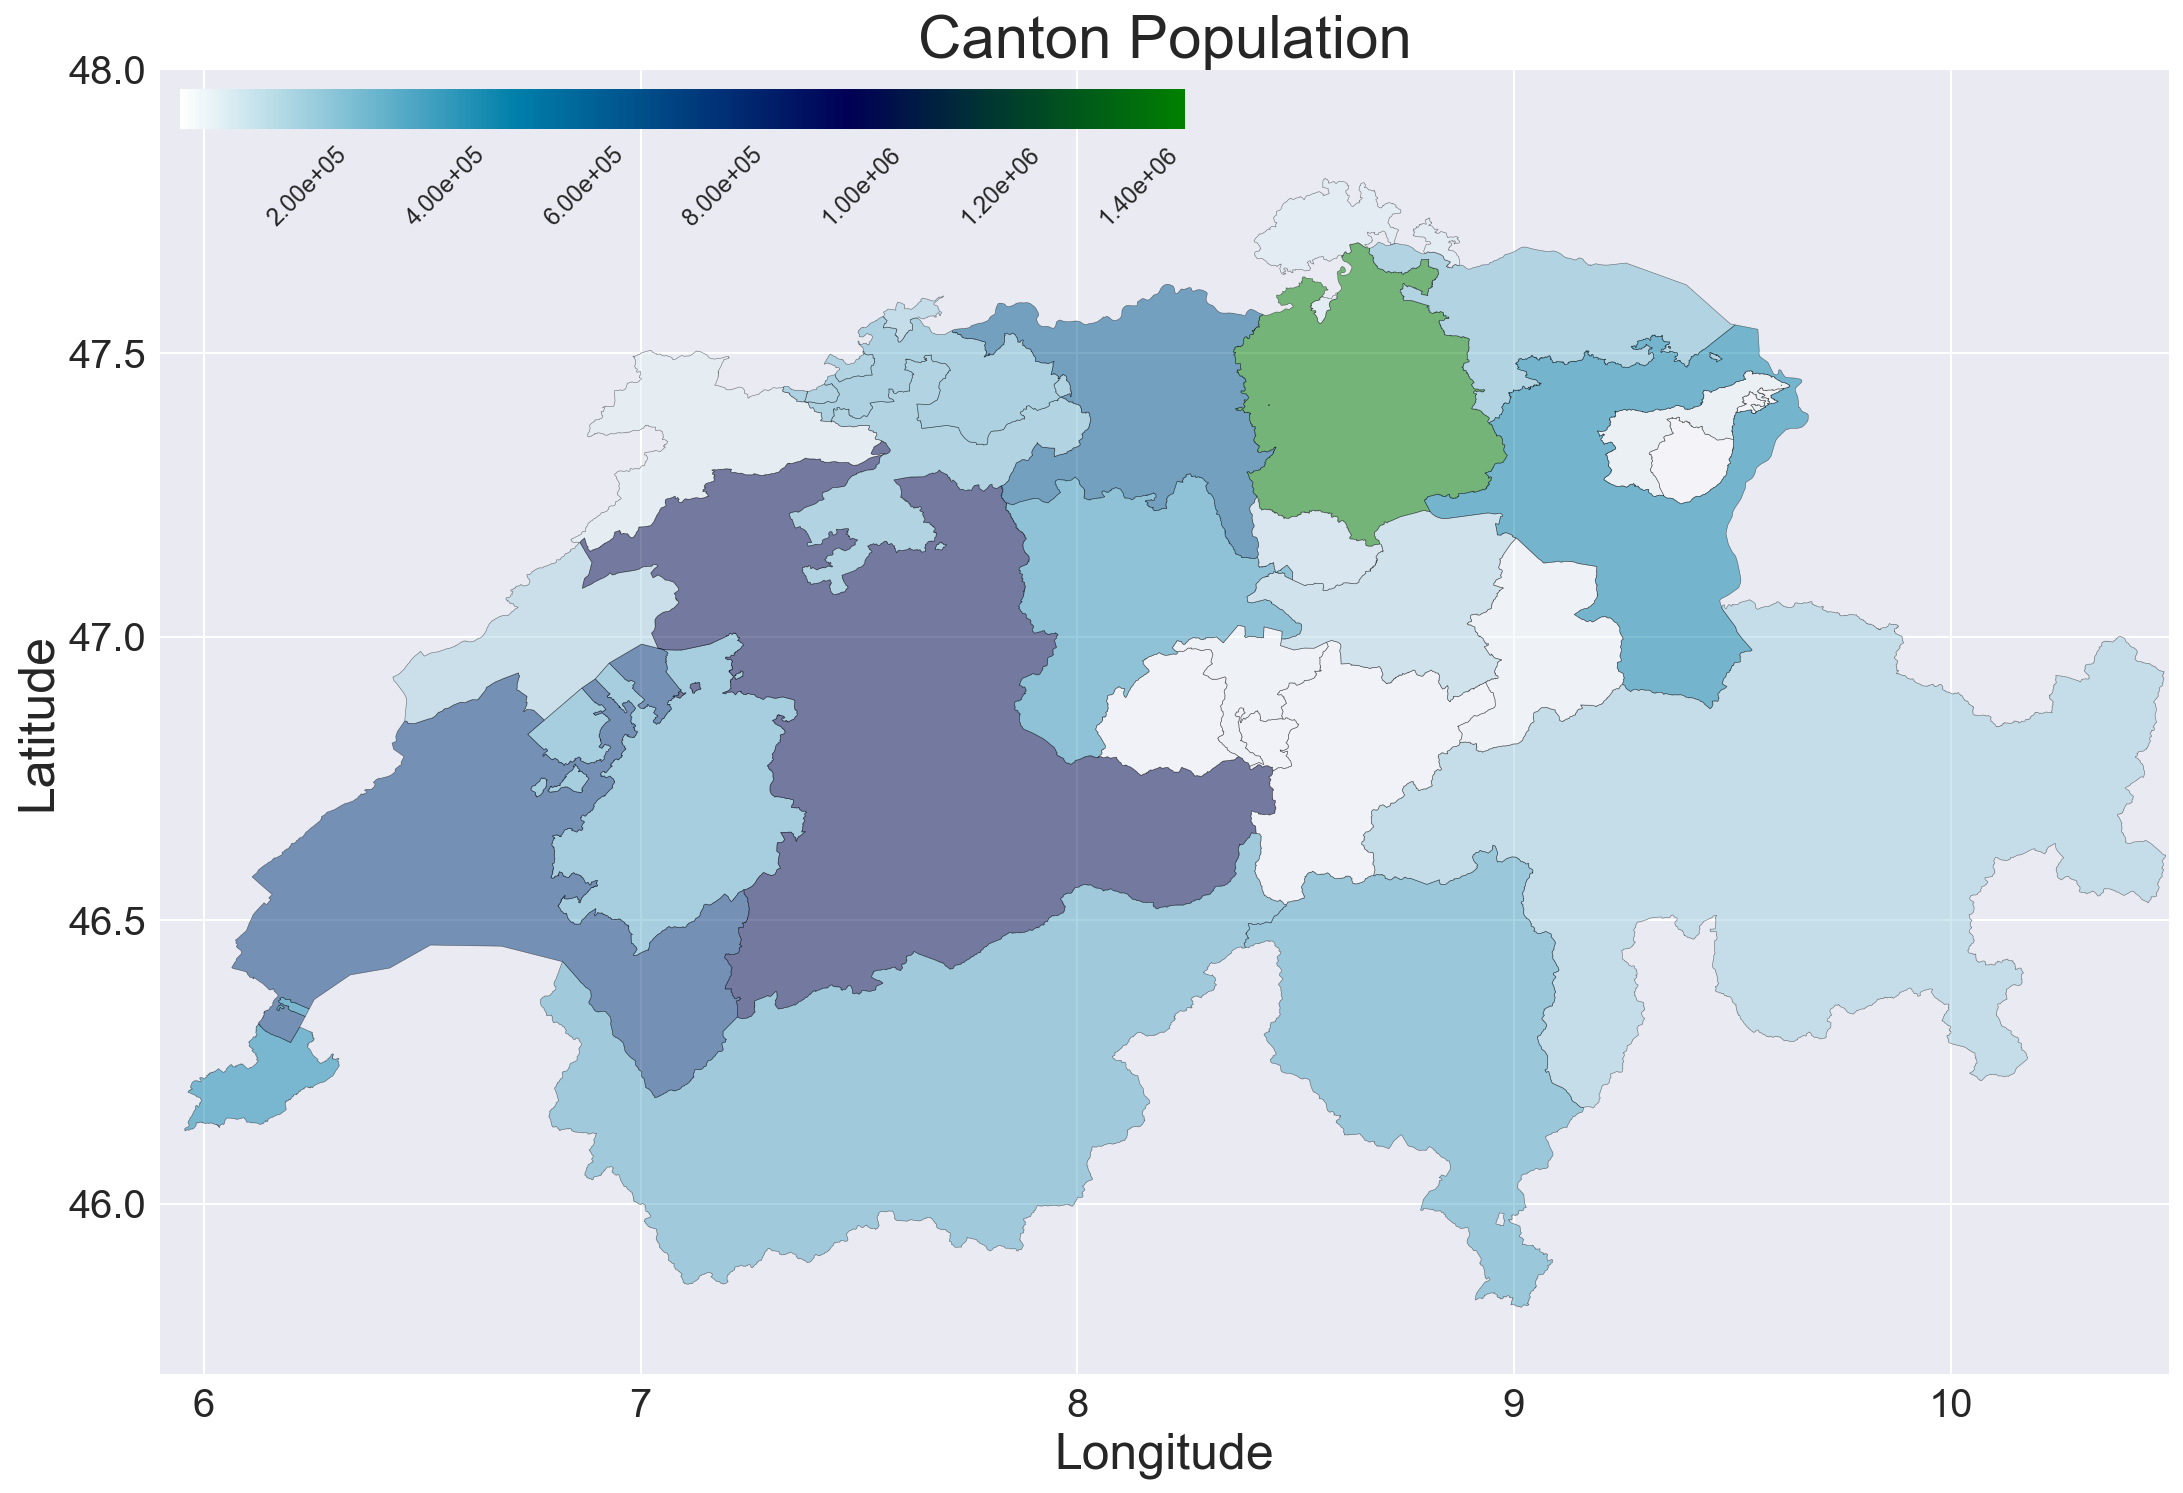

In [16]:
plotGeo(cmap, value, string, dfCan.canCoord)

## Plot District Population

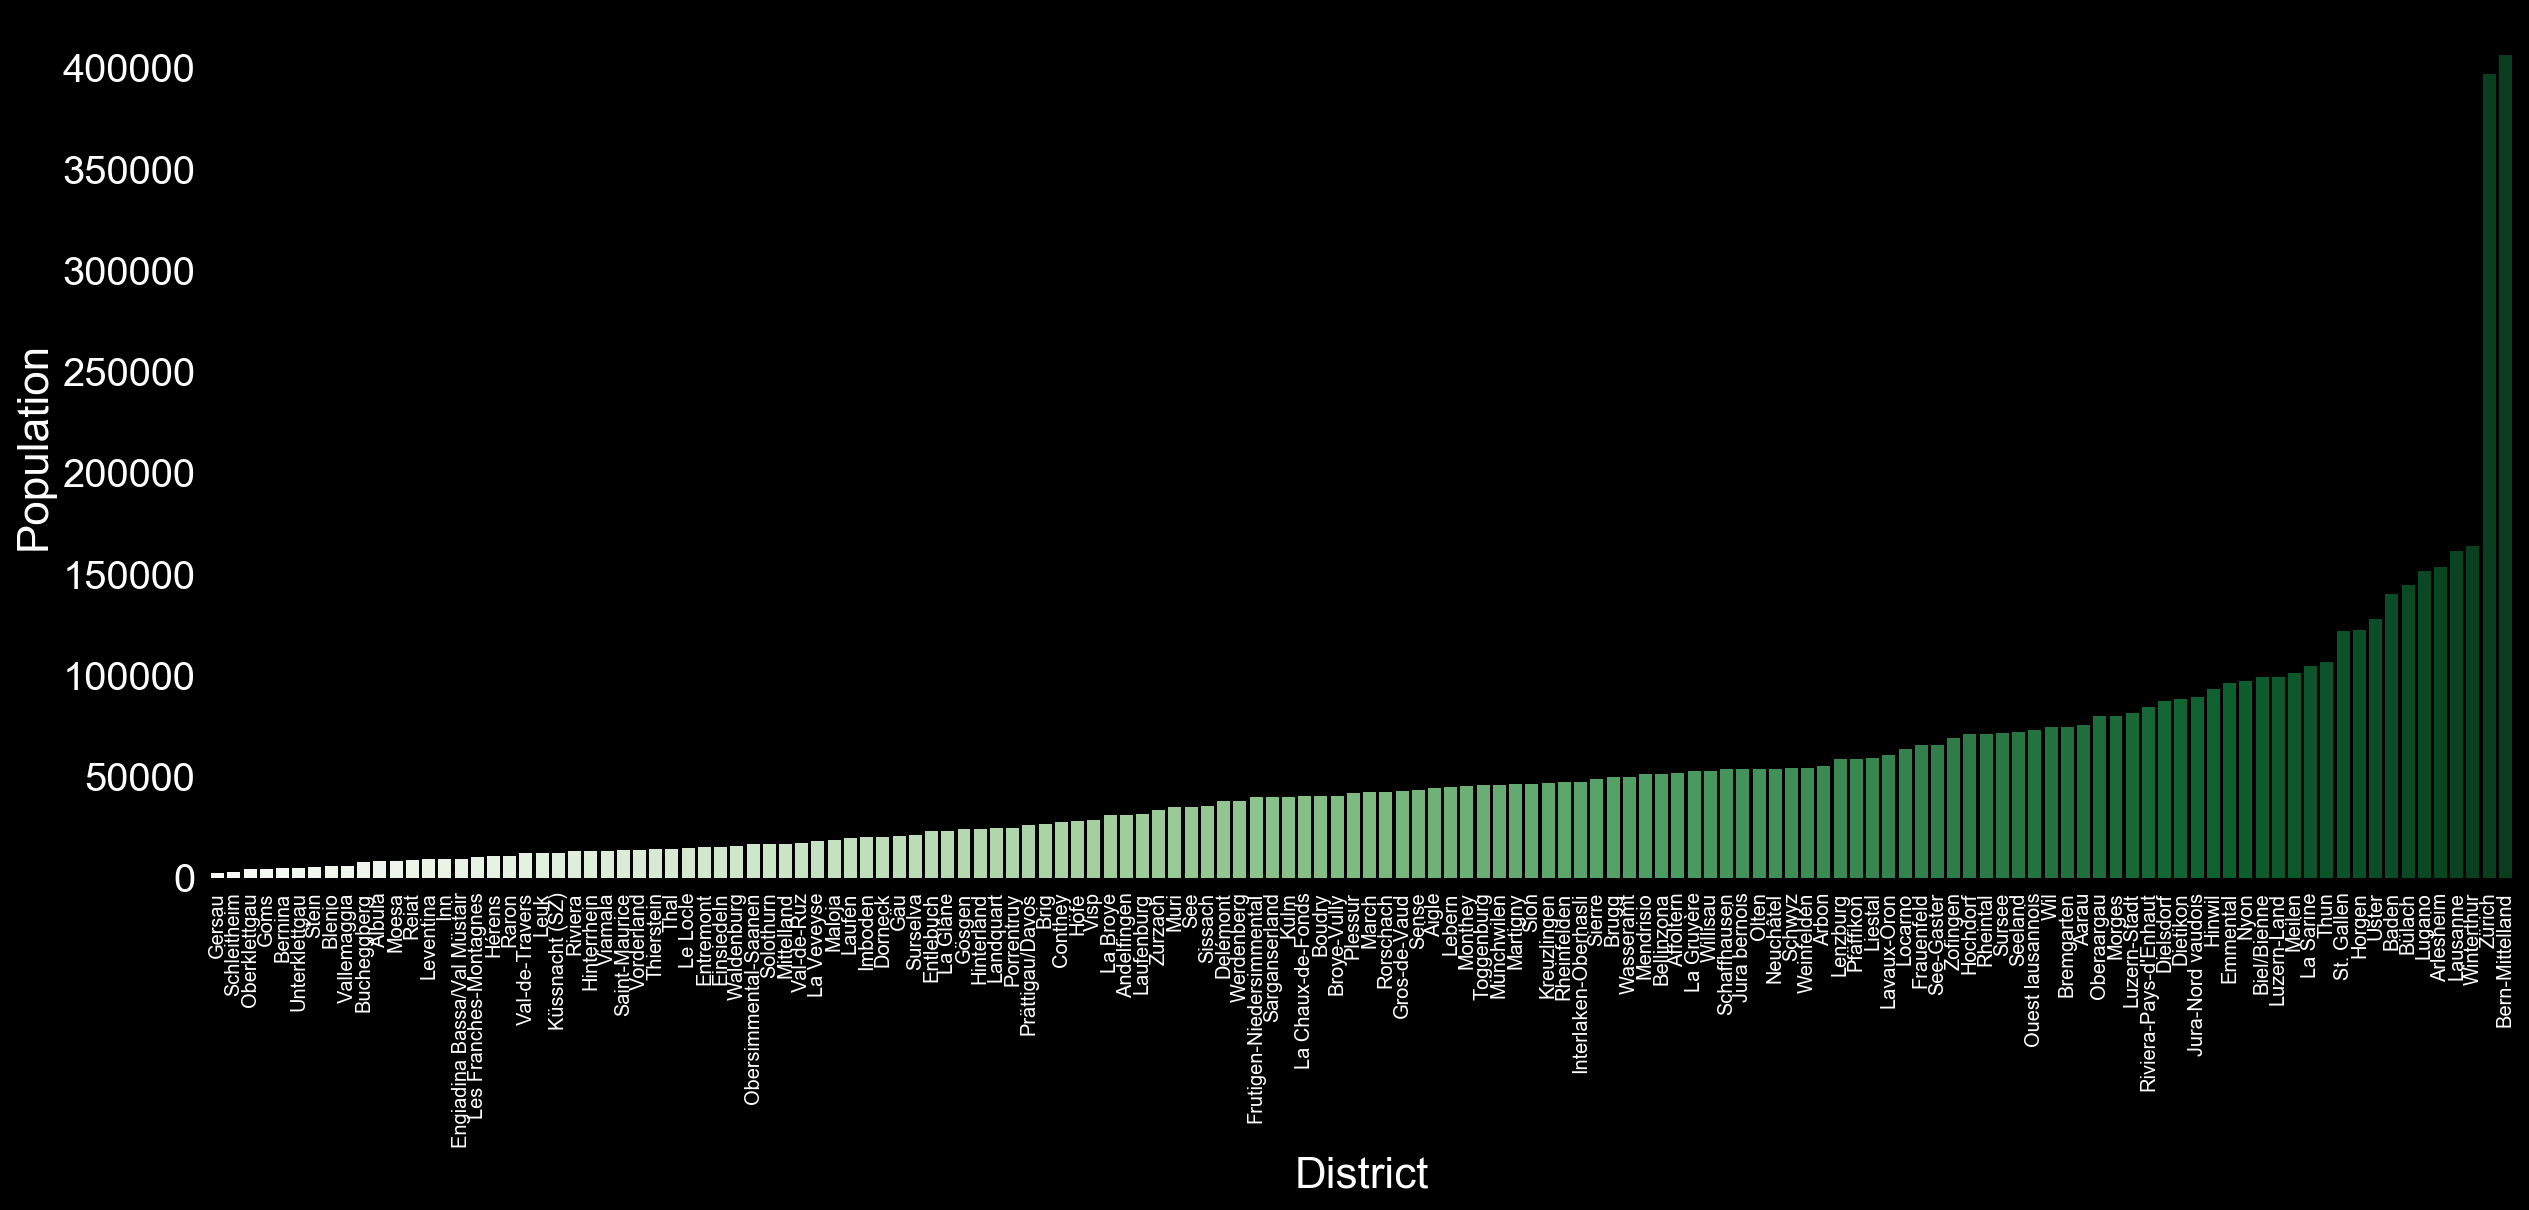

In [17]:
plotPopulation(dataSwiss, 'District', 'districtPopulation',10,20)

## Plot Municipality Population 2016

In [18]:
dataSwiss.Date = pd.to_datetime(dataSwiss.Date)

In [19]:
dfMun = dataSwiss[dataSwiss.Date == dataSwiss.Date[0]]
dfMun = dfMun.drop_duplicates('Code', keep='last').reset_index(drop=True)

In [20]:
dfMun.populationMunicipality = dfMun.populationMunicipality.astype(int)
pop = dfMun.populationMunicipality
value = log(pop)
string = 'Municipality Population[log] 2016'
cmap = plt.get_cmap('ocean_r')

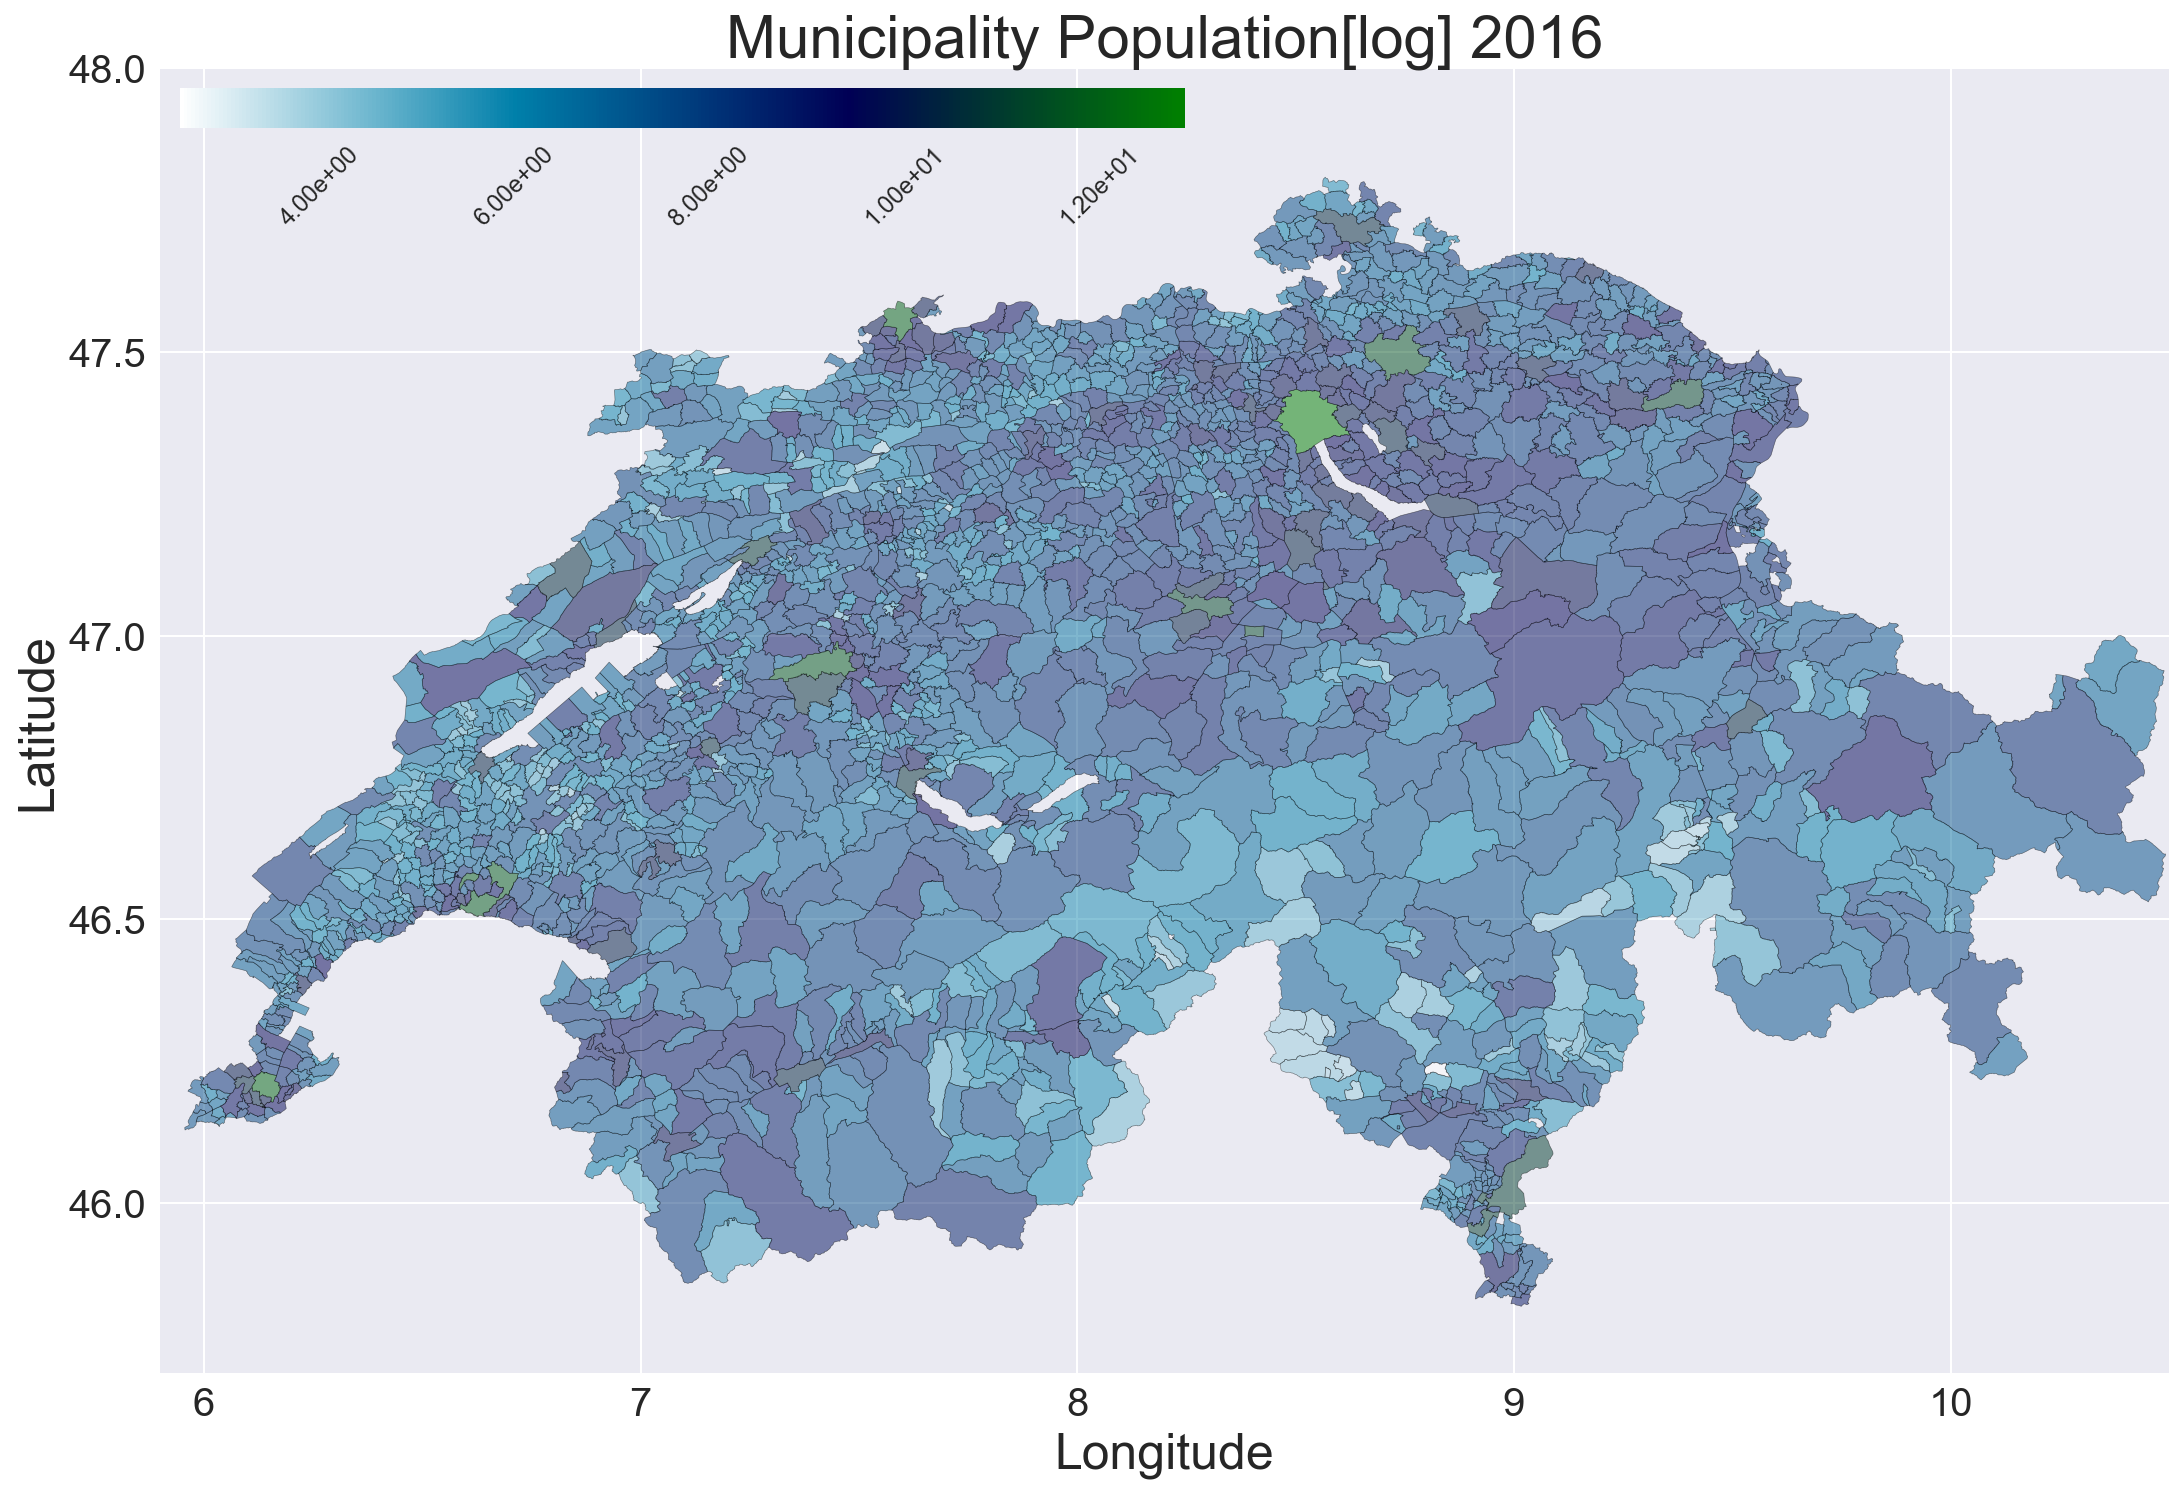

In [21]:
plotGeo(cmap, value, string, dfMun.munCoord)

In [22]:
dfMun.munArea = dfMun.munArea.astype(float)
pop = dfMun.populationMunicipality
value = log(pop / dfMun.munArea)
string = 'Municipality Population Density[log] 2016'
cmap = plt.get_cmap('ocean_r')

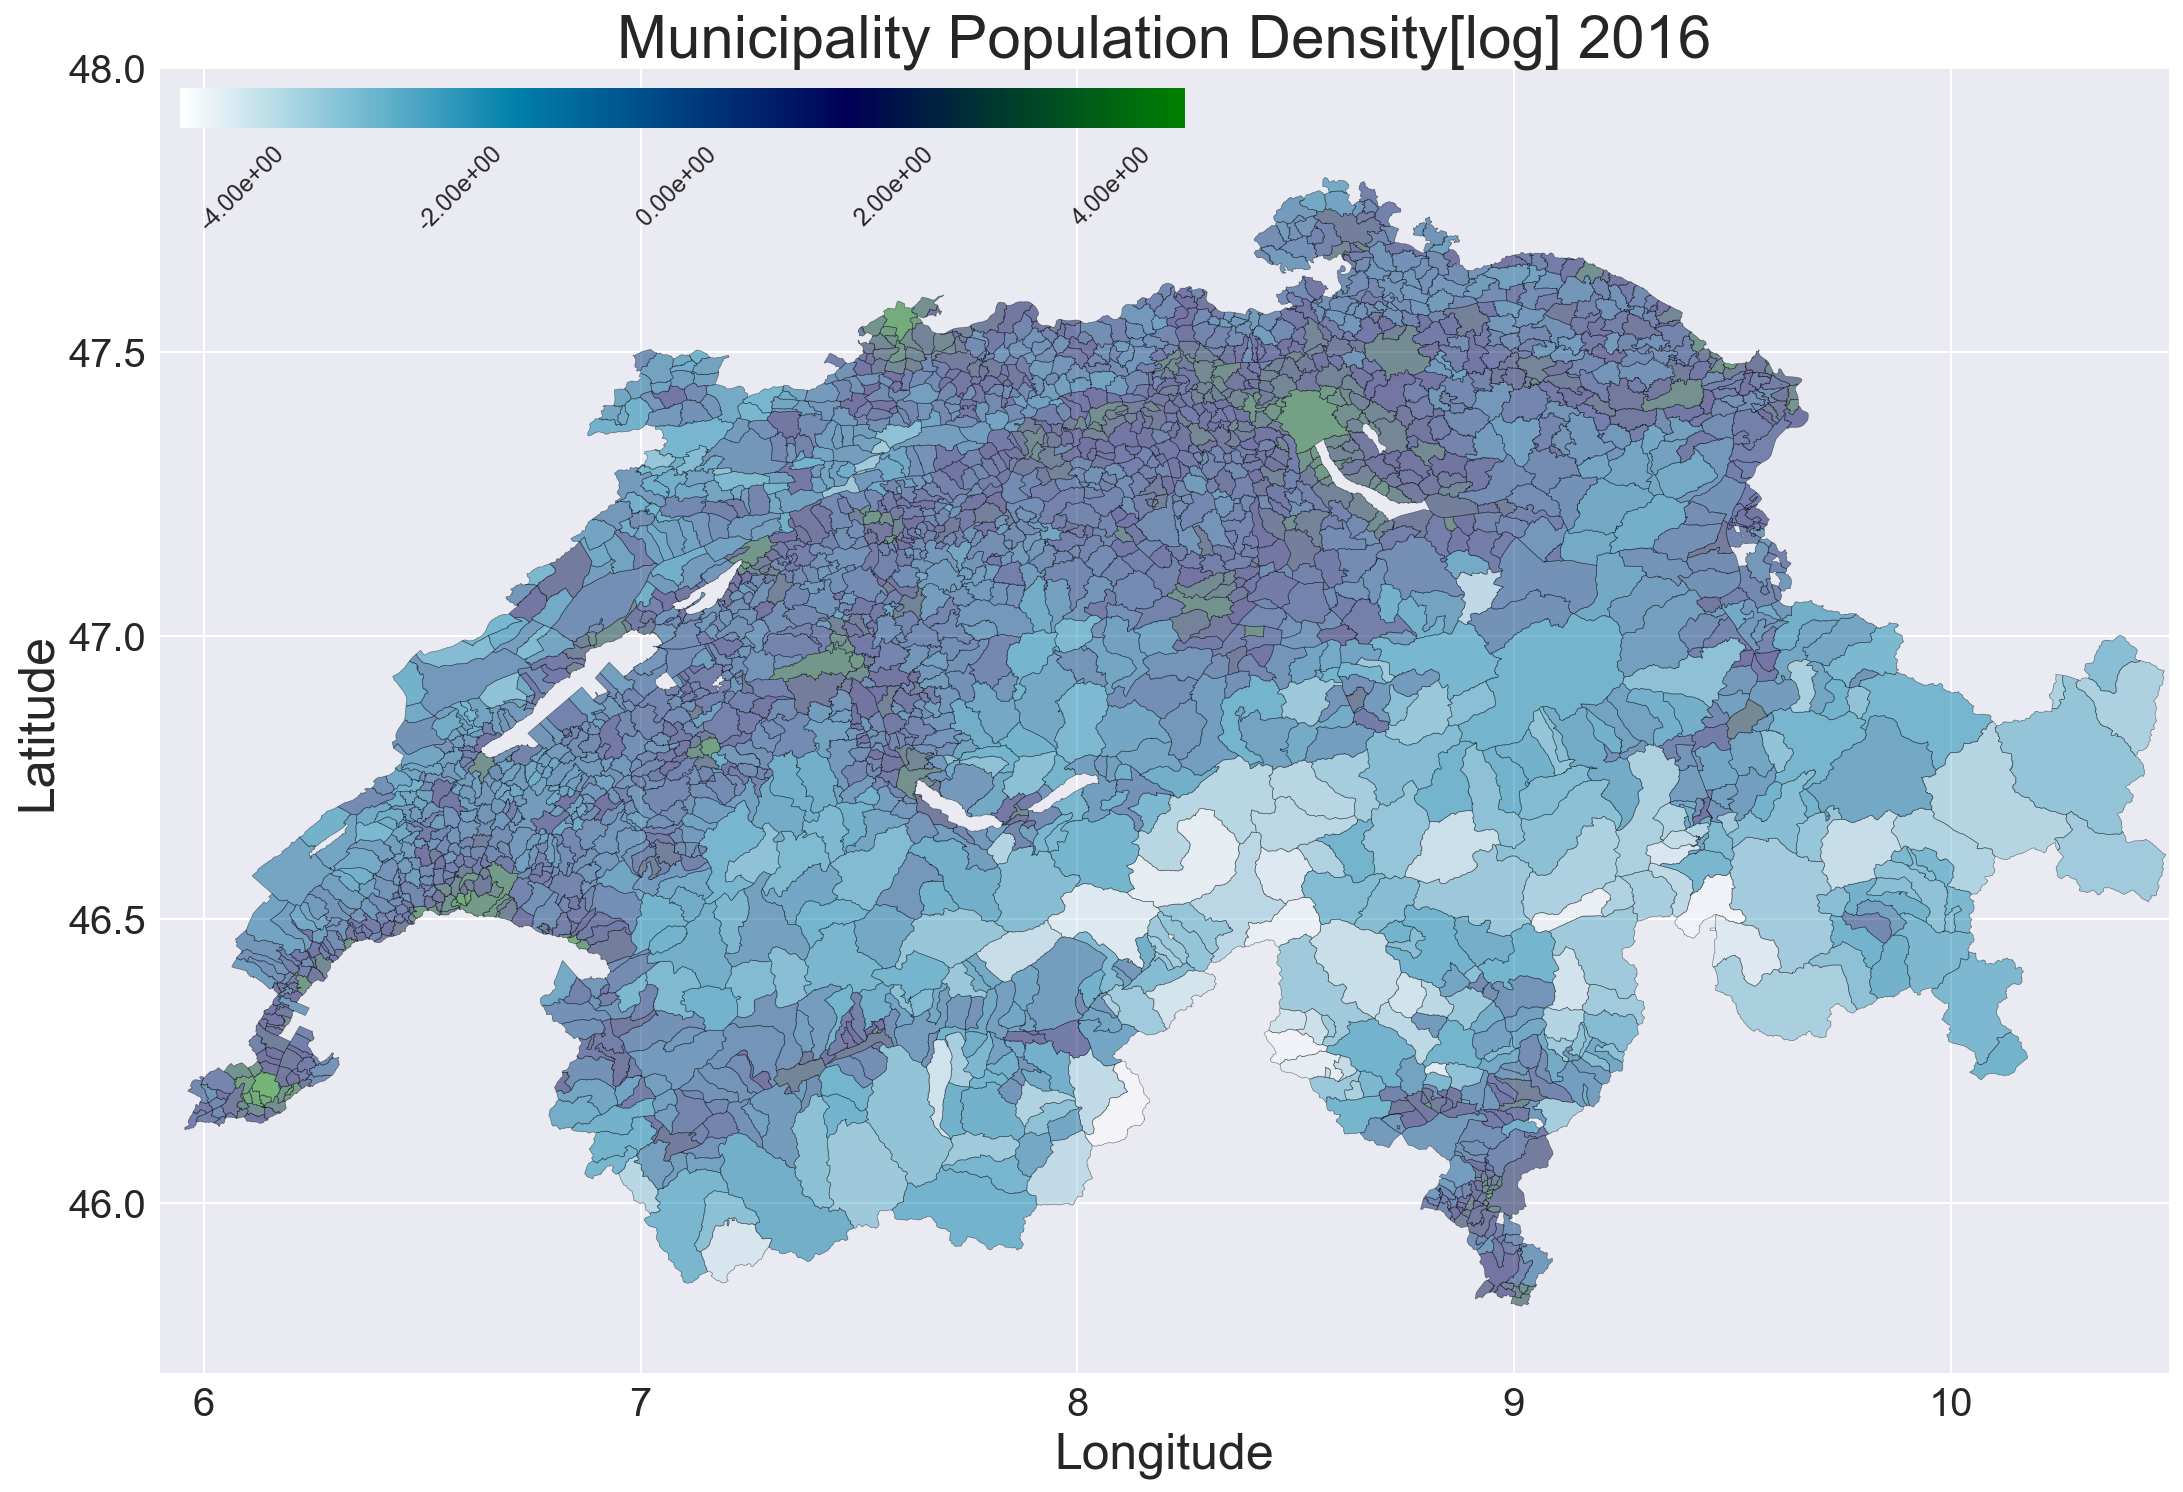

In [23]:
plotGeo(cmap, value, string, dfMun.munCoord)

# Create The Ontology

### Load Some Data

In [24]:
df = pd.read_csv('data/keyData2017.csv')

In [27]:
df.head(10)

Code     Name of commune  Residents  Change in %  \
0     1     Aeugst am Albis       1981         8.61   
1     2  Affoltern am Albis      11708         5.56   
2     3          Bonstetten       5326         3.24   
3     4     Hausen am Albis       3477         3.48   
4     5            Hedingen       3660         7.33   
5     6     Kappel am Albis       1033        12.53   
6     7              Knonau       2097        16.50   
7     8         Maschwanden        641         4.06   
8     9      Mettmenstetten       4669        10.04   
9    10            Obfelden       5009         6.89   

   Population density per km²  Foreign nationals in %  0-19 years  \
0                      250.44                   12.77       21.81   
1                     1105.57                   27.05       19.70   
2                      716.82                   14.03       24.03   
3                      255.66                   13.60       22.17   
4                      560.49                   14.86       22.84   
5                      130.43                   14.33       25.17   
6                      324.11                   16.31       23.37   
7                      136.67                   12.32       23.40   
8                      358.33                   14.20       21.82   
9                      664.32                   19.62       23.28   

   20-64 years  65 years or over  Crude marriage rate  \
0        62.04             16.15                 6.09   
1        62.99             17.31                 5.76   
2        61.17             14.80                 3.96   
3        60.71             17.11                 3.46   
4        62.35             14.81                 4.10   
5        60.70             14.13                 4.89   
6        61.37             15.26                 4.35   
7        60.84             15.76                 7.66   
8        61.79             16.38                 5.91   
9        60.37             16.35                 5.64   

             ...             FDP/PLR 2)   CVP     SP    SVP  EVP/CSP    GLP  \
0            ...                  18.69  2.08  18.65  30.93     3.47   8.44   
1            ...                  14.23  4.59  19.08  33.79     5.46   7.36   
2            ...                  16.47  3.38   20.4   29.1     3.14  11.86   
3            ...                  12.79  2.88  19.39  34.94     2.57   8.75   
4            ...                  15.81  3.92  22.48  30.11     3.59   9.63   
5            ...                  10.95  2.74  10.29  48.62      6.6   5.62   
6            ...                  11.46  3.13  18.44  32.88     6.17  10.42   
7            ...                   4.89   3.5  22.73  43.38     3.73   4.86   
8            ...                  13.18  3.65   18.8  35.67     3.47   9.62   
9            ...                  14.41  6.49  16.92  36.17     4.79   7.39   

    BDP  PdA/Sol.   GPS  Small right-wing parties  
0  2.62      0.17  7.08                      4.89  
1  4.16      0.19  6.21                      1.77  
2   3.8      0.11  6.66                      1.92  
3  4.66      0.19  8.02                      1.83  
4  3.77      0.23  6.47                      1.84  
5  5.13      0.31  4.38                      2.77  
6  5.94      0.01   5.8                      3.44  
7  3.45      0.64  5.17                      2.11  
8  4.35      0.13  5.06                      3.57  
9  4.36      0.09  3.71                      2.98  

[10 rows x 43 columns]

In [ ]:
schema = rdflib.Namespace('http://schema.org/')
time   = rdflib.Namespace('http://www.w3.org/2006/time#')
dbo    = rdflib.Namespace('http://dbpedia.org/ontology/')
dbp    = rdflib.Namespace('http://dbpedia.org/property/')
res    = rdflib.Namespace('http://dbpedia.org/resource/')
rdf    = rdflib.Namespace('http://www.w3.org/1999/02/22-rdf-syntax-ns#')
rdfs   = rdflib.Namespace('http://www.w3.org/2000/01/rdf-schema#')
gn     = rdflib.Namespace('http://www.geonames.org/ontology#')

In [ ]:
g = Graph()
FOCUS = Namespace("http://www.semanticweb.org/herus/Focus/")
g.bind("focus", FOCUS)

In [ ]:
municipality = URIRef(joao["municipality"])
# Add the OWL data to the graph
g.add((municipality, RDF.type, OWL.Class))
g.add((municipality, RDFS.subClassOf, OWL.Thing))
g.add((municipality, RDF.type, dbo.Municipality))
g.add((municipality, RDF.type, gn:A.ADM1))


In [ ]:
for i in df.index:
    code = df.code[i]
    tmp = 'city%d'%code

In [ ]:
g = Graph()
FOCUS = Namespace("http://www.semanticweb.org/herus/Focus/")
g.bind("focus", FOCUS)

In [ ]:

# Create the node to add to the Graph
country = URIRef(FOCUS["country"])
canton = URIRef(FOCUS["canton"])
district = URIRef(FOCUS["district"])
muncipality = URIRef(FOCUS["muncipality"])